Simulation complete ✔️


,year,mean_net_B$,median_net_B$,p5_B$,p95_B$,prob_deficit_%
0,1,-12.66,-12.52,-18.86,-7.27,100.0%
1,2,-12.80,-12.61,-18.58,-7.49,100.0%
2,3,-12.69,-12.53,-18.66,-7.21,100.0%
3,4,-12.71,-12.52,-18.86,-7.40,100.0%
4,5,-12.68,-12.43,-18.68,-7.26,100.0%
5,6,-12.69,-12.57,-18.61,-7.28,100.0%
6,7,-12.79,-12.60,-18.63,-7.51,100.0%
7,8,-12.70,-12.45,-18.84,-7.46,100.0%
8,9,-12.68,-12.49,-18.79,-7.16,100.0%
9,10,-12.59,-12.34,-18.57,-7.26,100.0%


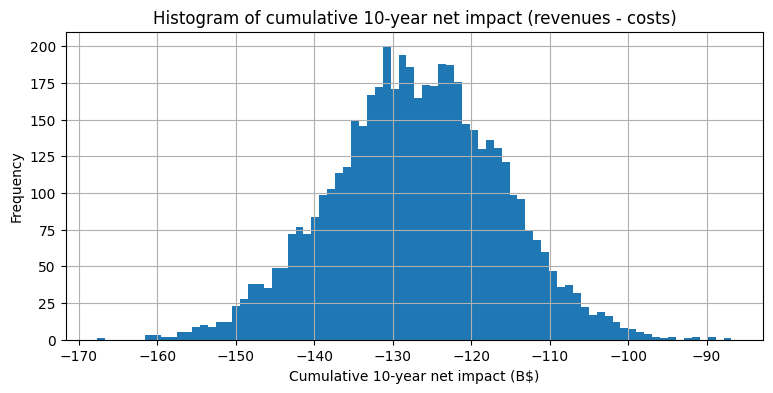

Mean final debt (10y) $B: 149.9586854217303
Median final debt (10y) $B: 149.83888526378723
P95 final debt (10y) $B: 171.48283188206307
Files saved: annual_net_simulations.csv , cumulative_10y_net.csv
Mounted at /content/drive
Copied to your Google Drive root (MyDrive).


In [4]:
# Cell 0: Imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)     # makes results repeatable

# Cell 1: ASSUMPTIONS - change these values freely
ASSUMPTIONS = {
    'SIMULATIONS': 5000,     # how many random worlds (increase for accuracy)
    'YEARS': 10,             # time horizon
    # Policy baseline annual numbers (B = billion USD)
    'housing_per_year': 10.0,
    'housing_sigma': 0.25,
    'free_buses_per_year': 0.75,
    'buses_sigma': 0.25,
    'childcare_per_year': 6.0,
    'childcare_sigma': 0.30,
    'grocery_per_year': 0.3,
    'grocery_sigma': 0.40,
    'safety_per_year': 0.5,
    'safety_sigma': 0.40,
    'millionaire_tax_per_year': 4.0,
    'millionaire_tax_sigma': 0.35,
    'corporate_tax_per_year': 1.0,
    'corporate_tax_sigma': 0.50,
    # Macro shocks
    'recession_prob': 0.15,
    'recession_revenue_drop': 0.30,
}
# Show current assumptions
pd.DataFrame(list(ASSUMPTIONS.items()), columns=['Parameter','Value'])

# Cell 2: helper functions
def lognormal_multiplier(sigma):
    """Return multiplier centered ~1 but variable (no negatives)."""
    mu = -0.5 * sigma**2
    return np.random.lognormal(mean=mu, sigma=sigma)
# Cell 3: Run Monte Carlo
S = int(ASSUMPTIONS['SIMULATIONS'])
T = int(ASSUMPTIONS['YEARS'])

annual_net = np.zeros((S, T))
annual_costs = np.zeros((S, T))
annual_revenues = np.zeros((S, T))

for sim in range(S):
    for y in range(T):
        recession = (np.random.rand() < ASSUMPTIONS['recession_prob'])
        # sample costs (each cost = baseline * random multiplier)
        housing = ASSUMPTIONS['housing_per_year'] * lognormal_multiplier(ASSUMPTIONS['housing_sigma'])
        buses = ASSUMPTIONS['free_buses_per_year'] * lognormal_multiplier(ASSUMPTIONS['buses_sigma'])
        childcare = ASSUMPTIONS['childcare_per_year'] * lognormal_multiplier(ASSUMPTIONS['childcare_sigma'])
        grocery = ASSUMPTIONS['grocery_per_year'] * lognormal_multiplier(ASSUMPTIONS['grocery_sigma'])
        safety = ASSUMPTIONS['safety_per_year'] * lognormal_multiplier(ASSUMPTIONS['safety_sigma'])
        total_cost = housing + buses + childcare + grocery + safety

        # sample revenues
        mill_tax = ASSUMPTIONS['millionaire_tax_per_year'] * lognormal_multiplier(ASSUMPTIONS['millionaire_tax_sigma'])
        corp_tax = ASSUMPTIONS['corporate_tax_per_year'] * lognormal_multiplier(ASSUMPTIONS['corporate_tax_sigma'])
        if recession:
            mill_tax *= (1 - ASSUMPTIONS['recession_revenue_drop'])
        total_revenue = mill_tax + corp_tax

        annual_costs[sim, y] = total_cost
        annual_revenues[sim, y] = total_revenue
        annual_net[sim, y] = total_revenue - total_cost  # positive -> net revenue, negative -> net cost

print("Simulation complete ✔️")

# Cell 4: Summaries
years = list(range(1, T+1))
summary_rows = []
for y in range(T):
    vals = annual_net[:, y]
    summary_rows.append({
        'year': y+1,
        'mean_net_B$': np.mean(vals),
        'median_net_B$': np.median(vals),
        'p5_B$': np.percentile(vals, 5),
        'p95_B$': np.percentile(vals, 95),
        'prob_deficit_%': 100 * np.mean(vals < 0)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df.style.format({"mean_net_B$":"{:.2f}", "median_net_B$":"{:.2f}", "p5_B$":"{:.2f}", "p95_B$":"{:.2f}", "prob_deficit_%":"{:.1f}%"}))

# cumulative
cumulative_net = annual_net.sum(axis=1)
cum_stats = {
    'mean_10y_net_B$': cumulative_net.mean(),
    'median_10y_net_B$': np.median(cumulative_net),
    'p5_10y_B$': np.percentile(cumulative_net, 5),
    'p95_10y_B$': np.percentile(cumulative_net, 95),
    'prob_cumulative_deficit_%': 100 * np.mean(cumulative_net < 0)
}
pd.DataFrame([cum_stats]).T.rename(columns={0:"Value"}).style.format("{:.2f}")

# Cell 5: Histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.hist(cumulative_net, bins=80)
plt.xlabel("Cumulative 10-year net impact (B$)")
plt.ylabel("Frequency")
plt.title("Histogram of cumulative 10-year net impact (revenues - costs)")
plt.grid(True)
plt.show()
# Cell 6: Sensitivity - test impact of turning off one policy at a time
base_cumulative = cumulative_net.mean()

policies = ['housing','free_buses','childcare','grocery','safety']
impacts = {}
for p in policies:
    # copy assumptions
    A = ASSUMPTIONS.copy()
    # set that policy to zero
    if p == 'housing': A['housing_per_year'] = 0.0
    if p == 'free_buses': A['free_buses_per_year'] = 0.0
    if p == 'childcare': A['childcare_per_year'] = 0.0
    if p == 'grocery': A['grocery_per_year'] = 0.0
    if p == 'safety': A['safety_per_year'] = 0.0

    # run quick reduced simulation (fewer sims for speed)
    S2 = 2000
    T2 = int(A['YEARS'] if 'YEARS' in A else ASSUMPTIONS['YEARS'])
    annual_net2 = np.zeros((S2, T2))
    for sim in range(S2):
        for y in range(T2):
            recession = (np.random.rand() < A['recession_prob'])
            housing = A['housing_per_year'] * lognormal_multiplier(A['housing_sigma'])
            buses = A['free_buses_per_year'] * lognormal_multiplier(A['buses_sigma'])
            childcare = A['childcare_per_year'] * lognormal_multiplier(A['childcare_sigma'])
            grocery = A['grocery_per_year'] * lognormal_multiplier(A['grocery_sigma'])
            safety = A['safety_per_year'] * lognormal_multiplier(A['safety_sigma'])
            total_cost = housing + buses + childcare + grocery + safety
            mill_tax = A['millionaire_tax_per_year'] * lognormal_multiplier(A['millionaire_tax_sigma'])
            corp_tax = A['corporate_tax_per_year'] * lognormal_multiplier(A['corporate_tax_sigma'])
            if recession: mill_tax *= (1 - A['recession_revenue_drop'])
            total_revenue = mill_tax + corp_tax
            annual_net2[sim, y] = total_revenue - total_cost
    impacts[p] = annual_net2.sum(axis=1).mean()

# Show how mean cumulative changes when we remove each policy
impact_df = pd.DataFrame({'policy':list(impacts.keys()), 'mean_10y_net_B$_without_policy':[impacts[p] for p in impacts]})
impact_df['difference_from_base'] = impact_df['mean_10y_net_B$_without_policy'] - base_cumulative
impact_df.sort_values('difference_from_base', inplace=True, ascending=False)
impact_df.style.format({"mean_10y_net_B$_without_policy":"{:.2f}", "difference_from_base":"{:.2f}"})

# Cell 7: Debt accumulation model (simple)
interest_rate = 0.03   # 3% annual interest on debt
initial_debt = 0.0     # start at zero for policy-specific debt

S = int(ASSUMPTIONS['SIMULATIONS'])
T = int(ASSUMPTIONS['YEARS'])
debt_paths = np.zeros((S, T))
for sim in range(S):
    debt = initial_debt
    for y in range(T):
        net = annual_net[sim, y]  # revenue - cost
        # if net < 0 we borrow amount = -net to cover gap
        if net < 0:
            debt += -net
        # accrue interest on existing debt
        debt *= (1 + interest_rate)
        debt_paths[sim, y] = debt

# show statistics for final year debt
final_debt = debt_paths[:, -1]
print("Mean final debt (10y) $B:", np.mean(final_debt))
print("Median final debt (10y) $B:", np.median(final_debt))
print("P95 final debt (10y) $B:", np.percentile(final_debt,95))

# Cell 8: Save outputs to CSV (in Colab storage)
pd.DataFrame(annual_net).to_csv("annual_net_simulations.csv", index=False)
pd.DataFrame(cumulative_net, columns=['cumulative_10y_net_B$']).to_csv("cumulative_10y_net.csv", index=False)
print("Files saved: annual_net_simulations.csv , cumulative_10y_net.csv")

# To save to your Google Drive (first run will ask for authorization):
from google.colab import drive
drive.mount('/content/drive')
!cp annual_net_simulations.csv /content/drive/MyDrive/
!cp cumulative_10y_net.csv /content/drive/MyDrive/
print("Copied to your Google Drive root (MyDrive).")
